##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial will show you how to build a basic speech recognition network that recognizes ten different words. It's important to know that real speech and audio recognition systems are much more complex, but like MNIST for images, it should give you a basic understanding of the techniques involved. Once you've completed this tutorial, you'll have a model that tries to classify a one second audio clip as "down", "go", "left", "no", "right", "stop", "up" and "yes".

## Setup

Import necessary modules and dependencies.

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

## Import the Speech Commands dataset

You'll write a script to download a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google and released under a CC BY license.

You'll be using a portion of the dataset to save time with data loading. Extract the `mini_speech_commands.zip` and load it in using the `tf.data` API.

In [4]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 1s 0us/step


Check basic statistics about the dataset.

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands !='README.md']
print('Commands:', commands)

Commands: ['no' 'yes' 'up' 'down' 'go' 'right' 'stop' 'left']


Extract the audio files into a list and shuffle it.

In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/right/35d1b6ee_nohash_2.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [7]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Reading audio files and their labels

The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. 
Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767. 
The sample rate for this dataset is 16kHz.
Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [8]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [9]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  if parts[-2] == 'down' or parts[-2] == "up" or parts[-2] == 'left' or parts[-2] == 'right':
    return "keyword" 
  else: 
    return "unknown"  

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

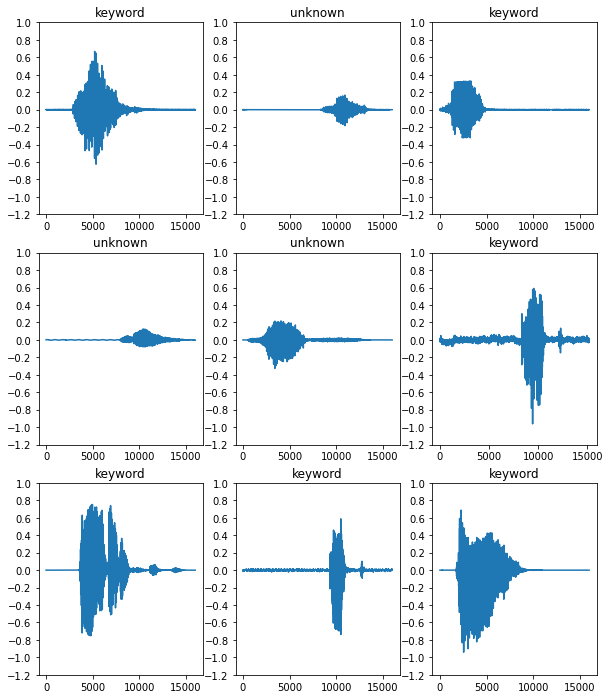

In [12]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing. 

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


In [13]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [14]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: keyword
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


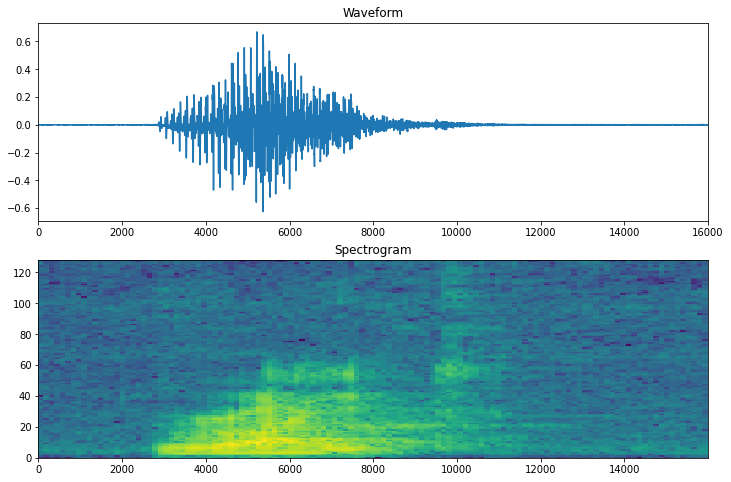

In [15]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [16]:
commands = ['keyword', 'unknown']

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [18]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


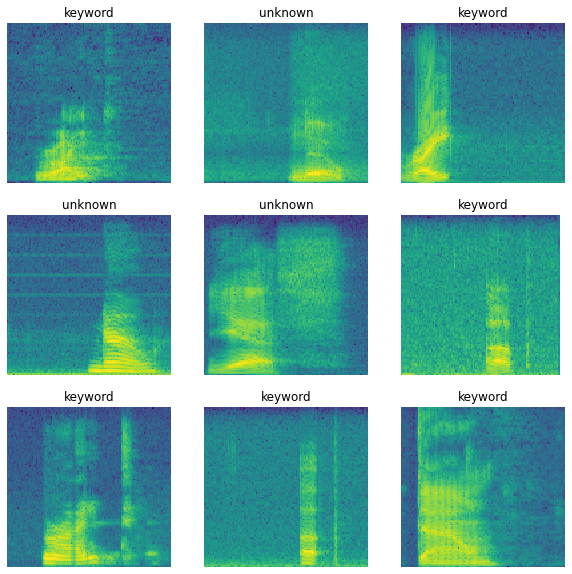

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [20]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [21]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [22]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [23]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

#cnn-trad-fpool3: 

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 40, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 33, 64)        10304     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 11, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 8, 64)          163904    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                

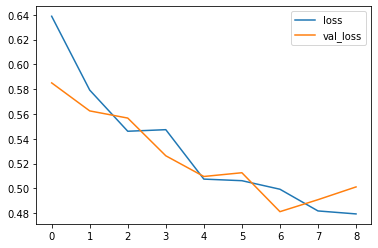

Test set accuracy: 82%


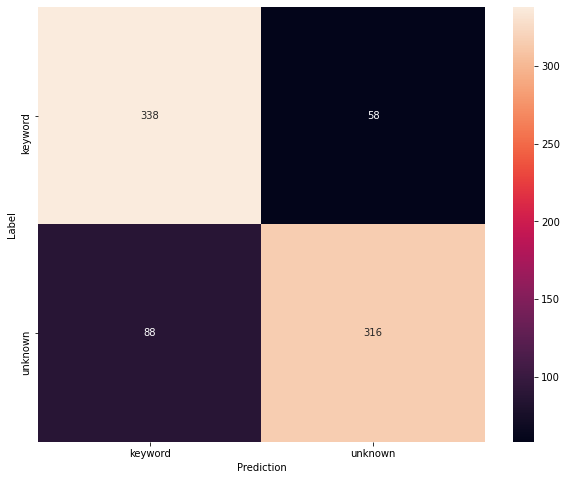

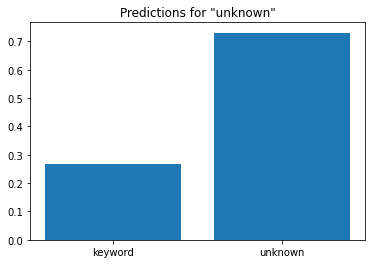

In [24]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 40), 
    norm_layer,
    layers.Conv2D(64, (20,8), strides=(1, 1), activation='relu'),
    layers.MaxPooling2D((1,3)),
    layers.Conv2D(64, (10,4),strides=(1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(128, activation = "relu"),
    layers.Dense(num_labels),
    layers.Softmax()
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


y_pred_1 = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred_1 == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_1) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [25]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_true, y_pred_1)
auc_model_1 = auc(fpr_1, tpr_1)

# cnn-one-fpool3


Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 40, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 33, 54)         13878     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 11, 54)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 594)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                19040     
_________________________________________________________________
dense_4 (Dense)            

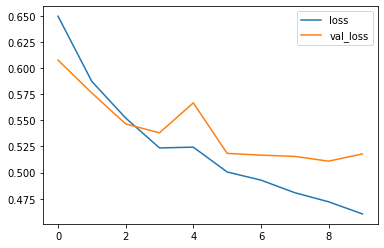

Test set accuracy: 78%


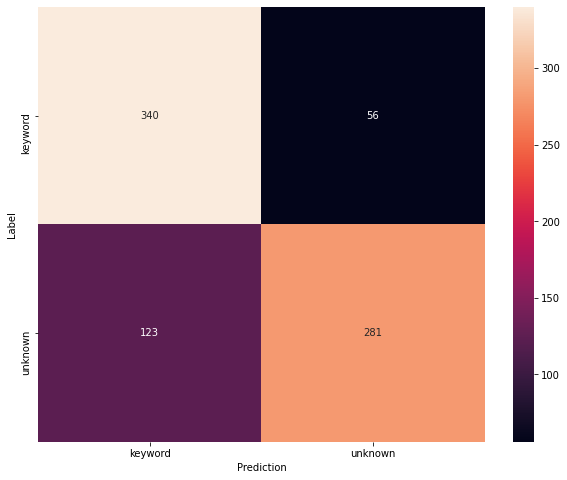

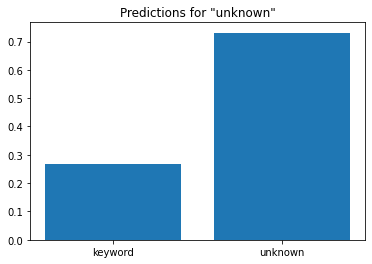

In [26]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 40), 
    norm_layer,
    layers.Conv2D(54, (32,8), strides=(1, 1), activation='relu'),
    layers.MaxPooling2D((1,3)),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(128, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(num_labels),
    layers.Softmax()
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


y_pred_2 = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred_2 == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_2) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [27]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_true, y_pred_2)
auc_model_2 = auc(fpr_2, tpr_2)

#cnn-one-fstride4

Input shape: (124, 129, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 40, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 9, 186)         47802     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1674)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                53600     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_9 (Dense)            

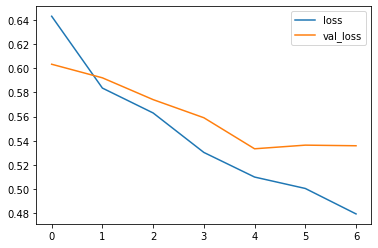

Test set accuracy: 79%


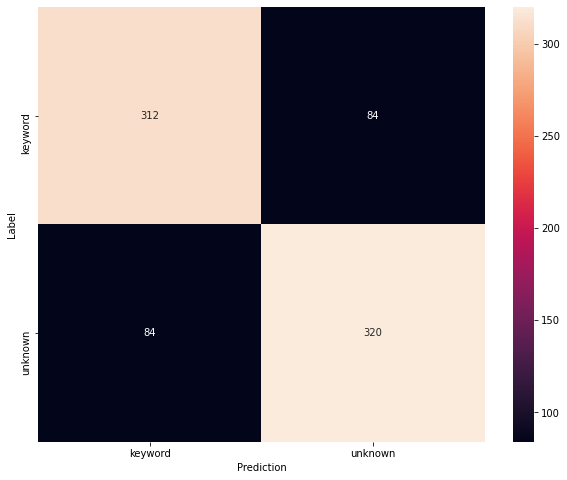

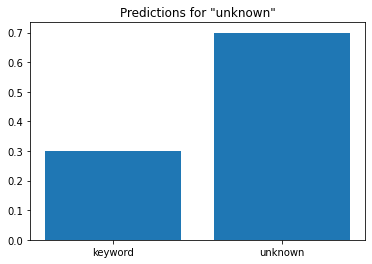

In [28]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 40), 
    norm_layer,
    layers.Conv2D(186, (32,8), strides=(1, 4), activation='relu'),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(128, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(num_labels),
    layers.Softmax()
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


y_pred_3 = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred_3 == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_3) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [29]:
fpr_3, tpr_3, thresholds_3 = roc_curve(y_true, y_pred_3)
auc_model_3 = auc(fpr_3, tpr_3)

# cnn-one-fstride8

Input shape: (124, 129, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 32, 40, 1)         0         
_________________________________________________________________
normalization_3 (Normalizati (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 5, 336)         86352     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1680)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                53792     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_13 (Dense)           

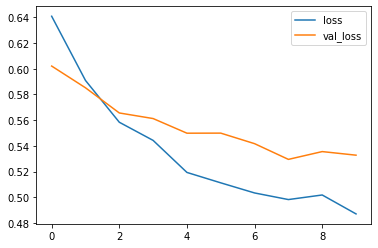

Test set accuracy: 77%


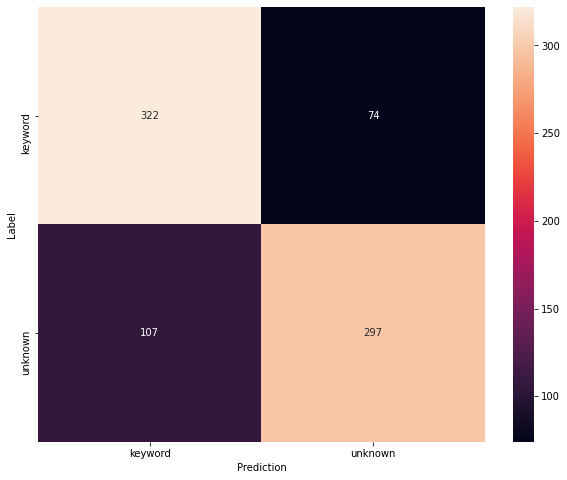

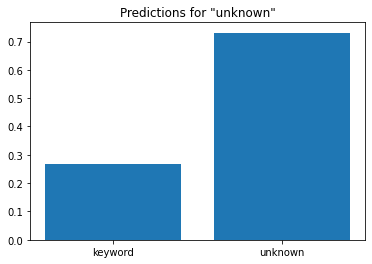

In [30]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 40), 
    norm_layer,
    layers.Conv2D(336, (32,8), strides=(1, 8), activation='relu'),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(128, activation = "relu"),
    layers.Dense(128, activation = "relu"),
    layers.Dense(num_labels),
    layers.Softmax()
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


y_pred_4 = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred_4 == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_4) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [31]:
fpr_4, tpr_4, thresholds_4 = roc_curve(y_true, y_pred_4)
auc_model_4 = auc(fpr_4, tpr_4)

# cnn-tstride2

Input shape: (124, 129, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 32, 40, 1)         0         
_________________________________________________________________
normalization_4 (Normalizati (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 33, 78)         10062     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 11, 78)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 8, 78)          219102    
_________________________________________________________________
flatten_4 (Flatten)          (None, 624)               0         
_________________________________________________________________
dense_15 (Dense)           

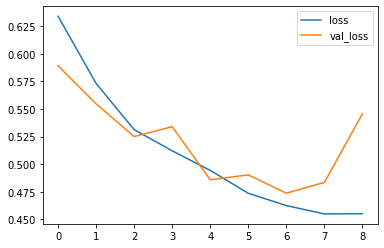

Test set accuracy: 77%


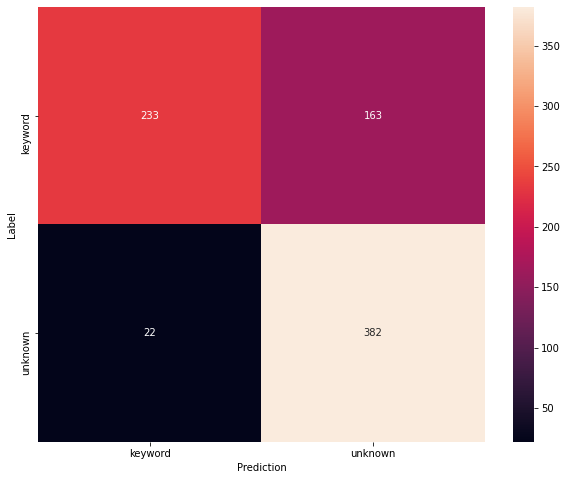

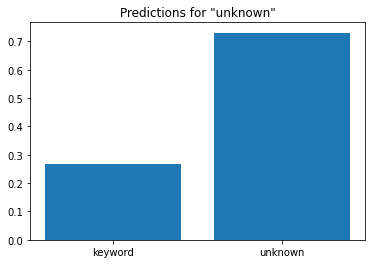

In [32]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 40), 
    norm_layer,
    layers.Conv2D(78, (16,8), strides=(2, 1), activation='relu'),
    layers.MaxPooling2D((1,3)),
    layers.Conv2D(78, (9,4), strides=(1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(num_labels),
    layers.Softmax()
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


y_pred_7 = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred_7 == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_7) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [33]:
fpr_7, tpr_7, thresholds_7 = roc_curve(y_true, y_pred_7)
auc_model_7 = auc(fpr_7, tpr_7)

# cnn-tstride4

Input shape: (124, 129, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_5 (Resizing)        (None, 32, 40, 1)         0         
_________________________________________________________________
normalization_5 (Normalizati (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 33, 100)        12900     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 11, 100)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 8, 78)          156078    
_________________________________________________________________
flatten_5 (Flatten)          (None, 624)               0         
_________________________________________________________________
dense_17 (Dense)           

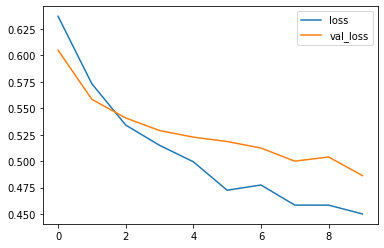

Test set accuracy: 83%


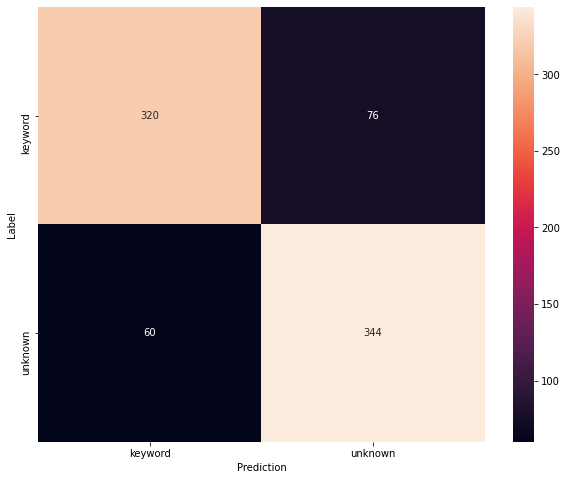

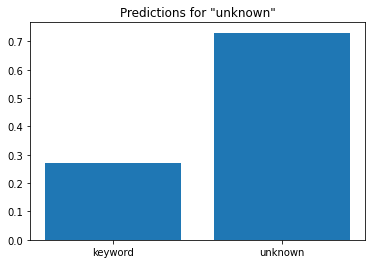

In [34]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 40), 
    norm_layer,
    layers.Conv2D(100, (16,8), strides=(4, 1), activation='relu'),
    layers.MaxPooling2D((1,3)),
    layers.Conv2D(78, (5,4), strides=(1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(num_labels),
    layers.Softmax()
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


y_pred_8 = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred_8 == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_8) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [35]:
fpr_8, tpr_8, thresholds_8 = roc_curve(y_true, y_pred_8)
auc_model_8 = auc(fpr_8, tpr_8)

# cnn-tstride8

Input shape: (124, 129, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_6 (Resizing)        (None, 32, 40, 1)         0         
_________________________________________________________________
normalization_6 (Normalizati (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 33, 126)        16254     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 11, 126)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 8, 78)          118014    
_________________________________________________________________
flatten_6 (Flatten)          (None, 624)               0         
_________________________________________________________________
dense_19 (Dense)           

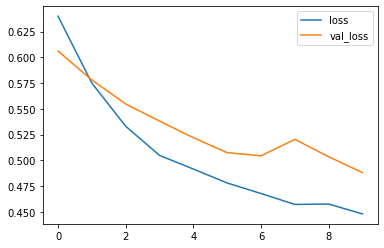

Test set accuracy: 85%


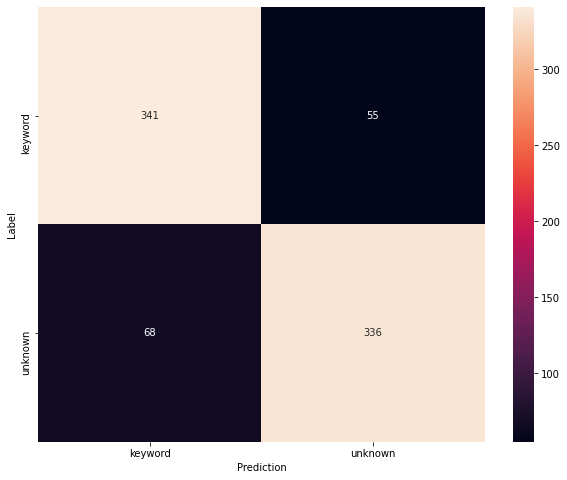

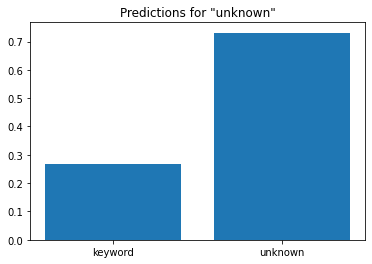

In [36]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 40), 
    norm_layer,
    layers.Conv2D(126, (16,8), strides=(8, 1), activation='relu'),
    layers.MaxPooling2D((1,3)),
    layers.Conv2D(78, (3,4), strides=(1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(num_labels),
    layers.Softmax()
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


y_pred_9 = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred_9 == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_9) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [37]:
fpr_9, tpr_9, thresholds_9 = roc_curve(y_true, y_pred_9)
auc_model_9 = auc(fpr_9, tpr_9)

#cnn-tpool2

Input shape: (124, 129, 1)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_7 (Resizing)        (None, 32, 40, 1)         0         
_________________________________________________________________
normalization_7 (Normalizati (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 33, 94)        15886     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 11, 94)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 8, 94)          212158    
_________________________________________________________________
flatten_7 (Flatten)          (None, 752)               0         
_________________________________________________________________
dense_21 (Dense)           

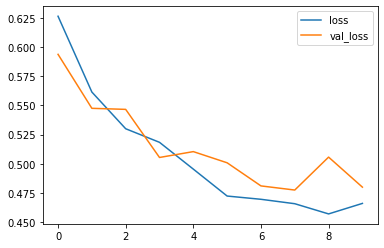

Test set accuracy: 85%


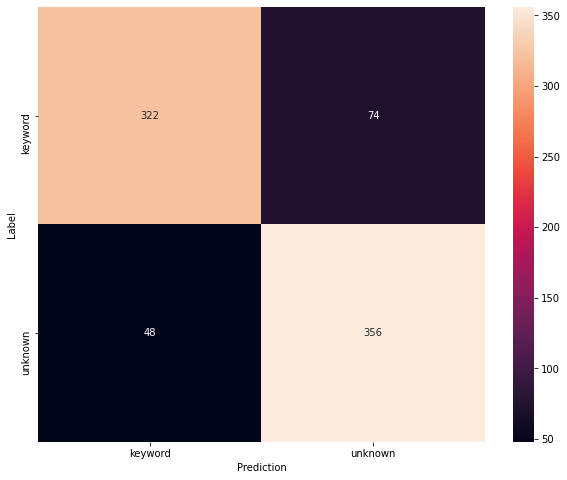

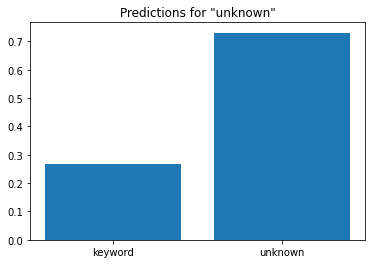

In [38]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 40), 
    norm_layer,
    layers.Conv2D(94, (21,8), strides=(1, 1), activation='relu'),
    layers.MaxPooling2D((2,3)),
    layers.Conv2D(94, (6,4), strides=(1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(num_labels),
    layers.Softmax()
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


y_pred_5 = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred_5 == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_5) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [39]:
fpr_5, tpr_5, thresholds_5 = roc_curve(y_true, y_pred_5)
auc_model_5 = auc(fpr_5, tpr_5)

# cnn-tpool4

Input shape: (124, 129, 1)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_8 (Resizing)        (None, 32, 40, 1)         0         
_________________________________________________________________
normalization_8 (Normalizati (None, 32, 40, 1)         3         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 18, 33, 94)        11374     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 11, 94)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 8, 94)          212158    
_________________________________________________________________
flatten_8 (Flatten)          (None, 752)               0         
_________________________________________________________________
dense_23 (Dense)           

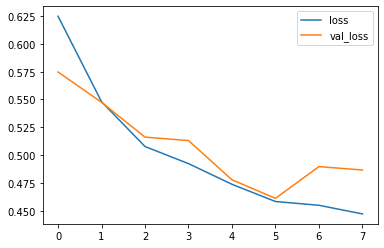

Test set accuracy: 85%


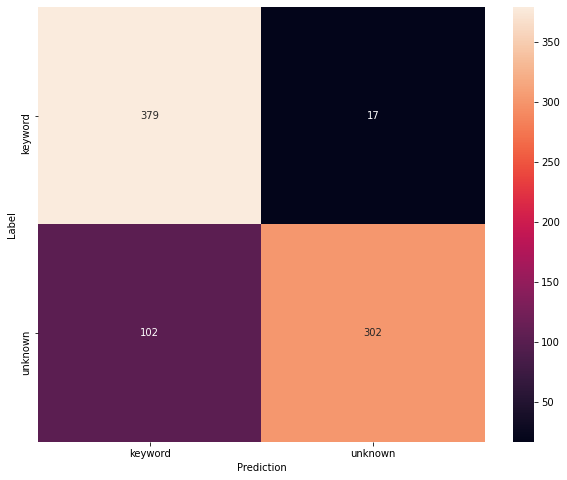

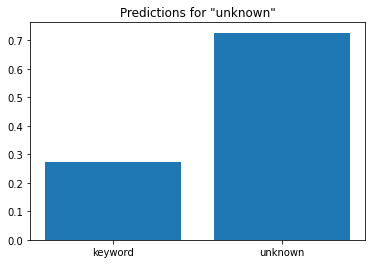

In [40]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 40), 
    norm_layer,
    layers.Conv2D(94, (15,8), strides=(1, 1), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(94, (6,4), strides=(1, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(32),
    layers.Dense(num_labels),
    layers.Softmax()
])

model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


y_pred_6 = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred_6 == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')



confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_6) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()


In [41]:
fpr_6, tpr_6, thresholds_6 = roc_curve(y_true, y_pred_6)
auc_model_6 = auc(fpr_6, tpr_6)

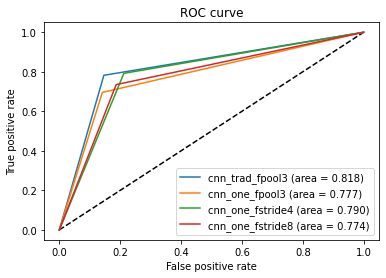

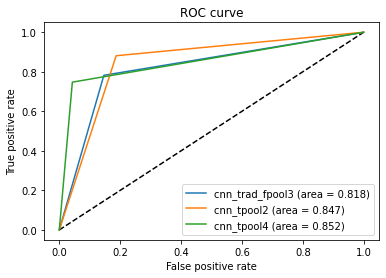

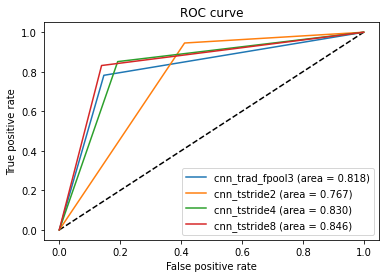

In [42]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='cnn_trad_fpool3 (area = {:.3f})'.format(auc_model_1))
plt.plot(fpr_2, tpr_2, label='cnn_one_fpool3 (area = {:.3f})'.format(auc_model_2))
plt.plot(fpr_3, tpr_3, label='cnn_one_fstride4 (area = {:.3f})'.format(auc_model_3))
plt.plot(fpr_4, tpr_4, label='cnn_one_fstride8 (area = {:.3f})'.format(auc_model_4))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='cnn_trad_fpool3 (area = {:.3f})'.format(auc_model_1))
plt.plot(fpr_5, tpr_5, label='cnn_tpool2 (area = {:.3f})'.format(auc_model_5))
plt.plot(fpr_6, tpr_6, label='cnn_tpool4 (area = {:.3f})'.format(auc_model_6))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='cnn_trad_fpool3 (area = {:.3f})'.format(auc_model_1))
plt.plot(fpr_7, tpr_7, label='cnn_tstride2 (area = {:.3f})'.format(auc_model_7))
plt.plot(fpr_8, tpr_8, label='cnn_tstride4 (area = {:.3f})'.format(auc_model_8))
plt.plot(fpr_9, tpr_9, label='cnn_tstride8 (area = {:.3f})'.format(auc_model_9))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()




